# X-ray instrument respones: the basics

This tutorial discusses the basics of the response matrices of X-ray instruments, and discusses how they can be applied to models in nDspec.

In [1]:
import sys
import os
import gc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
import matplotlib.gridspec as gridspec

from matplotlib import rc, rcParams
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Computer Modern']})
fi = 22
plt.rcParams.update({'font.size': fi-5})

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from ndspec.Response import ResponseMatrix

from xspec import *

## Load and visualize the instrument response

An instrument response is typically stored in two files: the rmf, and the arf. The redistribution matrix, or rmf, contains information on how an instruments reconstructs the energy of a photon after detecting it. In practice, for each physical, incoming photon energy, the rmf contains a probability distribution for a photon to be assigned within an instrument ``channel''; each channel corresponds to a measured photon energy. The effective area, or arf, contains the sensitivity of an instrument as a function of photon energy, typically in units of cm$^{2}$. Sometimes, the two are combined in a single file.

We will start by loading the NICER rmf from path ```filepath``` by initializing an instance of the class ```ResponseMatrix```. The NICER response is separated in rmf and arf files; the initializer recognizes this and automatically prompts the user to pass an arf file through the ```load_arf method```. If instead the full response is contained in just one file (e.g. for RXTE), the class will recognize this and not prompt the user for an additional arf file. Note that for missions when the option to separate the arf from the rmf is left to the user during reduction (e.g. NuSTAR), the prompt to load the arf may be misleading.

In [2]:
rmfpath = os.getcwd()+"/data/nicer-rmf6s-teamonly-array50.rmf"
nicer_matrix = ResponseMatrix(rmfpath)
arfpath = os.getcwd()+"/data/nicer-consim135p-teamonly-array50.arf"
nicer_matrix.load_arf(arfpath)

Arf missing, please load it
Arf loaded


We can now visualize the response matrix with the ```plot_response``` method. This creates a 2d plot with either channel or channel bound (in units of keV) on the x axis (using the ````plot_type```` flag), incoming photon energy on the y axis, and logarithm of instrument response on the z axis; darker colors correspond to larger instrument response. We can notice three things. 

First, the peak of the response is on a diagonal line, with channel bound (or channel timtes 100 for NICER) roughly equal to incoming energy at least up to 10 keV or so. For example, an incoming 6 keV photon will generally be recorded around channel 600, whose energy bounds are close to 6 keV. In other words we can roughly map channel to photon energy. This is true for most X-ray observatories; in the case of NICER specifically, the ratio is roughly 1 keV to 100 channels.

Second, the bottom left of the plot where channel bound >> incoming energy is zero, while the top left is not. This means that a) a low energy photon will never be recorded in a high (energy) channel, but b) the opposite can happen. Therefore, while we can map channels to energy, this is only an approximation of how the photons are being recorded by the instrument.

Third, note how the low energy, bottom part of the plot is darker than the top. This is the effect of the NICER effective area, which peaks at 3 keV or so and drops off significantly afterwards.

After plotting the response, we call the Python garbage collector to clean up the memory, as this is something Jupyter can struggle with for large 2d plots.

/home/matteo/Software/nDspec/src/ndspec/Response.py:515: RuntimeWarning: divide by zero encountered in log10
  p = plt.pcolormesh(x_axis,energy_array,np.log10(self.resp_matrix),


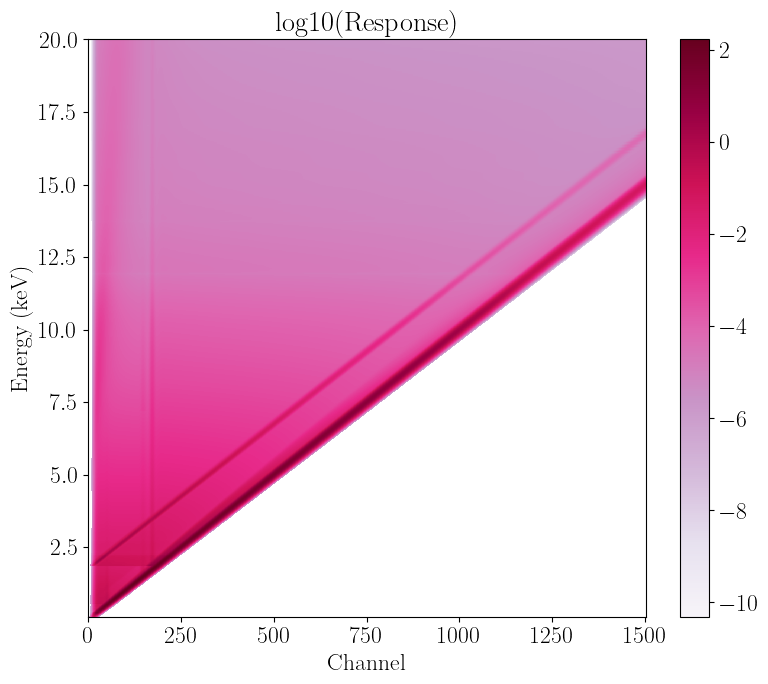

/home/matteo/Software/nDspec/src/ndspec/Response.py:515: RuntimeWarning: divide by zero encountered in log10
  p = plt.pcolormesh(x_axis,energy_array,np.log10(self.resp_matrix),


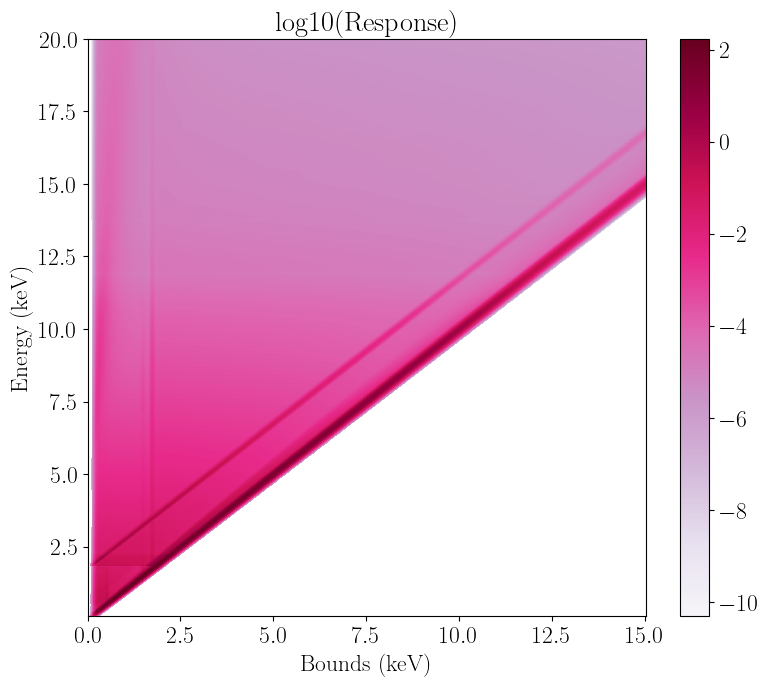

11587

In [3]:
nicer_matrix.plot_response()
nicer_matrix.plot_response(plot_type="energy")

gc.collect()

Similarly, we can visualize the NICER effective area as a function of photon energy with the ```plot_arf``` method:

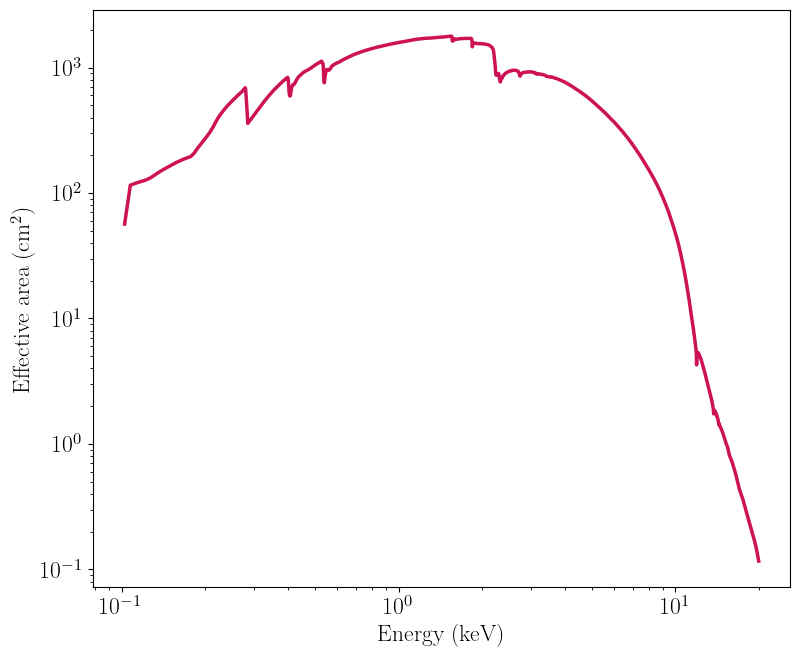

In [4]:
nicer_matrix.plot_arf()

## Define a basic model and compare with PyXspec

As a starting point, let us fold a standard one-dimensional spectral model with the response we just loaded, and then compare the result with PyXspec. For the model, we will use a simple power-law with normalization unity and slope 0. To ease the comparison, the model defined here uses the same units as the Xspec/Heasoft library: photon flux multiplied by bin width dE, as a function of photon energy.

After defining the model, let us convolve it with the response using nDspec. When we do so, we need to specify whether our model has already been multiplied by the bin width, as is the case for Xspec models (using the keyword ```units_in```), and whether we want the output count rate to be in units of counts/s/keV or counts/s/channel (using the keyword ```units_out```). 

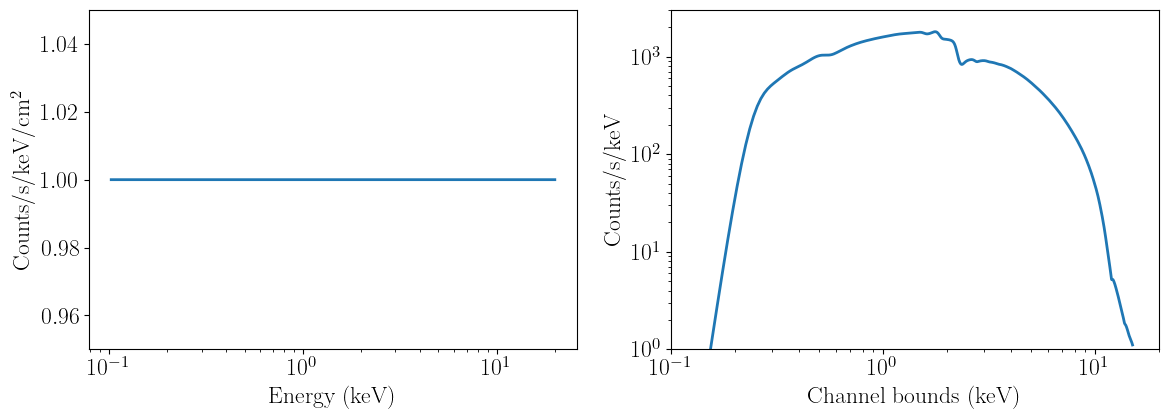

In [5]:
#define our powerlaw model - this is identical to the code in models.py
def powerlaw(array, params):
    norm = params[0]
    slope = params[1]
    model = norm*np.power(array,slope)
    return model

#define the energy bin mid points and widths, from the matrix we just loaded
nicer_grid = 0.5*(nicer_matrix.energ_hi+nicer_matrix.energ_lo)
nicer_bins = nicer_matrix.energ_hi-nicer_matrix.energ_lo

#define the model and convolve it with the response
pl_params = np.array([1.,0.])
ndspec_model = powerlaw(nicer_grid,pl_params)*nicer_bins
ndspec_fold = nicer_matrix.convolve_response(ndspec_model,units_in="xspec",units_out="kev")
channel_grid = 0.5*(nicer_matrix.emax+nicer_matrix.emin)

#plot the unfolded (left) and folded (right) models for comparison
fig, ((ax1, ax2))  = plt.subplots(1,2,figsize=(12,4.5))
ax1.plot(nicer_grid,ndspec_model/nicer_bins,lw=2)
ax1.set_xscale("log")
ax1.set_ylim([0.95,1.05])
ax1.set_xlabel("Energy (keV)")
ax1.set_ylabel("Counts/s/keV/cm$^{2}$")

ax2.plot(channel_grid,ndspec_fold,lw=2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Channel bounds (keV)")
ax2.set_ylabel("Counts/s/keV")
ax2.set_xlim([0.1,20.])
ax2.set_ylim([1,3e3])

fig.tight_layout()

The unfolded model (on the left) behaves as we would expect - it is simply a constant across all energies. Instead, the convolved model resemles the effective area curve, except the features in it have been smoothed out. This is due to the rmf re-distributing photons away from the sharp features in the arf.

Now, let us perform the same operation but in PyXspec, and compare the two to make sure they are identical. 

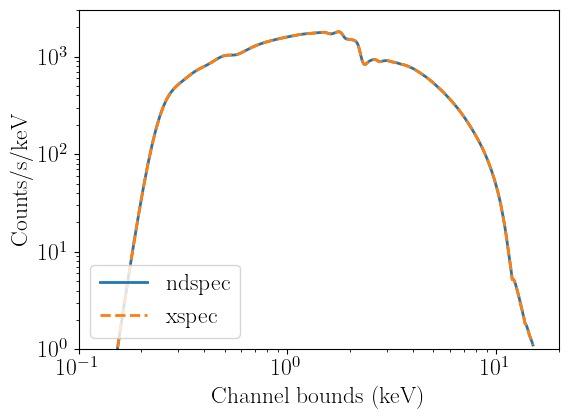

In [6]:
Xset.chatter = 0

#load a sample nicer spectrum - this is necessary to set the energy grids in PyXspec
placeholder = Spectrum(os.getcwd()+"/data/nicer_unbinned.pha")
placeholder.response = os.getcwd()+"/data/nicer-rmf6s-teamonly-array50.rmf"
placeholder.response.arf = os.getcwd()+"/data/nicer-consim135p-teamonly-array50.arf"

#define our model
m1 = Model("powerlaw")
m1.powerlaw.PhoIndex = 0.  
m1.powerlaw.norm = 1.

#initialize our plot of the folded spectrum, and compare it with the nDspec model
Plot.xAxis = "kev"
Plot("ldata")
modVals = Plot.model()     
chans = Plot.x()

fig, (ax1)  = plt.subplots(1,1,figsize=(6,4.5))

ax1.plot(channel_grid,ndspec_fold,label='ndspec',lw=2)
ax1.plot(chans,modVals,label='xspec',ls='--',lw=2)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Channel bounds (keV)")
ax1.set_ylabel("Counts/s/keV")
ax1.legend(loc='lower left')
ax1.set_xlim([0.1,20.])
ax1.set_ylim([1,3e3])

fig.tight_layout()

## Define and visualize a multi-dimensional model

Next, let us define a time-dependent model that one might use for a reverberation signal: the impulse response function of a gaussian line following a fast rise, exponential decay becoming narrower over the decay. 

Like one-dimensional models, our impulse response is defined in "energy space": the model provides photon count rate against time and (incoming) photon energy, i.e., the y-axis when we plot a response, but the data we work with is always in count rate per channel, ie, the x-axis. 

In order to actually compute the model, we need to assume a grid of energies and one of times. For times, let us just take 250 bins between 0.1 and 400 timescales in our putative system (say, the gravitational time t=R\_g/c). 

For the energy grid we have to be more careful, as this needs to be identical to the grid over which the response is binned - the y-axis in the plots above. Therefore, we will need to use the same array as our powerlaw - the mid point of the ```energ_lo``` and ```energ_hi``` arrays defined in the response. We will assume a centroid line energy of 6 keV, an initial width of 2.5 keV, and rise and decay timescales of 10 and 60 R\_g/c:

In [7]:
#define our model functions:
def gaussian(array, params):
    center = params[0]
    width = params[1]
    norm = np.multiply(np.sqrt(2.0*np.pi),width)
    shape = np.exp(-np.power((array - center)/width,2.0)/2)
    line = shape/norm 
    return line

def powerlaw(array, params):
    norm = params[0]
    slope = params[1]
    model = norm*np.power(array,slope)
    return model

def gauss_fred(array1,array2,params):
    times = array1
    energy = array2
    norm = params[0]
    width = params[1]
    center = params[2]
    rise_t = params[3]
    decay_t = params[4]
    decay_w = params[5]
    sigma = width*powerlaw(times,np.array([1.,decay_w]))
    fred_profile = np.exp(np.nan_to_num(-rise_t/times)-np.nan_to_num(times/decay_t))
    fred_pulse = np.zeros((len(energy),len(times)))
    line_profile = np.zeros(len(energy))
    pulse_profile = np.zeros(len(times))
    for i in range(len(times)):
        fred_pulse[:,i] = gaussian(energy,np.array([center,sigma[i]]))*fred_profile[i]    
    line_profile = np.sum(fred_pulse,axis=1)
    pulse_profile = np.sum(fred_pulse,axis=0)
    return fred_pulse, line_profile, pulse_profile

#define a time grid and evaulaute the model defined earlier
time_res = 250
time_array = np.linspace(0.1,400,time_res)

#this time, we do not multiply by the bin width because it makes visualizing the 2d model a bit easier
impulse_test, line_profile, pulse_profile = gauss_fred(time_array,nicer_grid,[1.,2.5,6.0,10,60,-0.25])

## Visualize the model

Now let us make a similar 2d plot as above to visualize our model. We can also project the model in either the time direction (to obtain the time-averaged spectrum) or in the energy direction (to obtain the lightcurve). The code below is analogous to the function ```plot_2d``` defined in models.py.

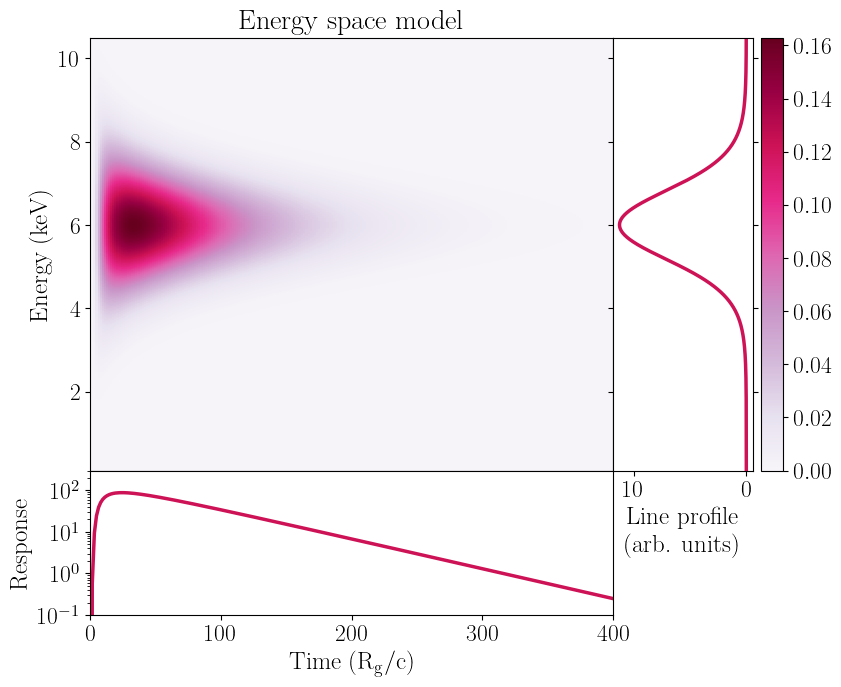

15

In [8]:
colorscale = pl.cm.PuRd(np.linspace(0.,1.,5))

fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

c = ax.pcolormesh(time_array,nicer_grid,impulse_test,cmap="PuRd",
                  shading='auto',linewidth=0,rasterized=True)
ax.set_xticklabels([])
ax.set_ylim([0.1,10.5])
ax.set_xlim([0,400])
ax.set_ylabel("Energy (keV)",fontsize=18)
ax.xaxis.set_visible(False)

below.semilogy(time_array,pulse_profile,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_ylim([1e-1,3e2])
below.set_xlim([0,400])

side.plot(line_profile,nicer_grid,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_yticklabels([], minor=False)
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_ylim([0.1,10.5])

fig.colorbar(c, ax=side)

ax.set_title("Energy space model")

plt.show()

gc.collect()

## Convolve the 2d model with the instrument response

We can now obtain a "detector space", two-dimensional model in identical fashion to the one-dimensional case - we simply convolve instrument response we have loaded with the model we have calculated with the ```convolve_response``` method. Note that while we can compare one-dimensional models to Xspec, we can not do so with more a more generic mode.

Regardless, it is this convolved model that is appropriate for comparison with the data. Note that if we could map photon energy to channels this step could be avoided - mathematically, this corresponds to a diagonal response matrix, with elements equal to only 0 or 1. All we would need to do is factor in the instrument effective area. This is typically the case for lower wavelength (e.g optical or infrared) data, and is nominally supported in nDspec through the ````diagonal_matrix```` method of a ````ResponseMatrix```` object. 

In [9]:
convolved_model = nicer_matrix.convolve_response(impulse_test,units_in='rate')

Let us plot our model again, but this time in "detector space" after the convolution. We can note two important things.

First, the peak of the line is at channels < 600, even though the Gaussian centroid we provided is at 6 keV and for NICER we expect channels to roughly map 1:100 to photon energies. This is caused by the telescope effective area, which drops as energy increases. Therefore, the model normalization at channel 600 will be lower than, say, at channel 550. 

Second, some small features that appear between channels 100 and 250. These are prooduce by instrumental features in the redistribution matrix and effective area we plotted above.

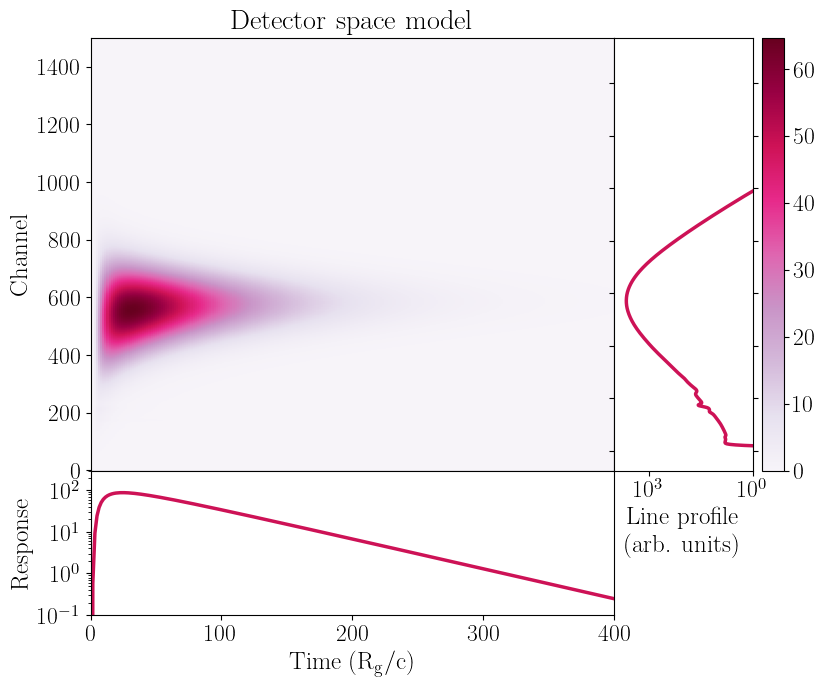

14725

In [10]:
#plot the model again to visualize it:
convolved_line_profile = np.sum(convolved_model,axis=1)

colorscale = pl.cm.PuRd(np.linspace(0.,1.,5))

fig = plt.figure(figsize=(9.,7.5))

gs = gridspec.GridSpec(200,200) 
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:-50,:-50])
side = plt.subplot(gs[:-50,-50:200])
below = plt.subplot(gs[-50:200,:-50])

c = ax.pcolormesh(time_array,nicer_matrix.chans,convolved_model,cmap="PuRd",
                  shading='auto',linewidth=0,rasterized=True)

ax.set_xticklabels([])
ax.set_xlim([0,400.])
ax.xaxis.set_visible(False)
ax.set_ylabel("Channel",fontsize=18)

below.semilogy(time_array,pulse_profile,linewidth=2.5,color=colorscale[3])
below.set_xlabel("Time ($\\rm{R_g}/c$)",fontsize=18)
below.set_ylabel("Response",fontsize=18)
below.set_xlim([0,400.])
below.set_ylim([1e-1,3e2])

side.plot(convolved_line_profile,nicer_matrix.chans,linewidth=2.5,color=colorscale[3])
side.invert_xaxis()
side.yaxis.tick_right()
side.yaxis.set_label_position('right')
side.yaxis.set_ticks_position('both')
side.set_yticklabels([], minor=False)
side.set_xlabel("Line profile \n (arb. units)",fontsize=18)
side.set_xscale("log")
side.set_xlim([1e4,1])

fig.colorbar(c, ax=side)

ax.set_title("Detector space model")

plt.show()
gc.collect()

## Benchmark the convolution:

Finally, let us compare the difference in performance between convolving a one- and two- dimensional model with the instrument response:

In [11]:
from timeit import Timer

print("One-d convolution runtime:")
%timeit nicer_matrix.convolve_response(ndspec_model,units_in="xspec",units_out="kev")

print("Two-d convolution runtime:")
%timeit nicer_matrix.convolve_response(impulse_test,units_in='rate')

One-d convolution runtime:
10.2 ms ± 787 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Two-d convolution runtime:
30.2 ms ± 4.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Note that the two-d model convolution is un-surprisingly somewhat slower - this is because we have to perform the same one-dimensional operation once for each time bin. Thanks to the optimizations within Numpy, the end result is not as long as running 250 individual convolutions, but for complex spectral timing models it could still be long enough to complicate model fitting and inference. 